In [160]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import math

In [161]:
SEQUENCE_LENGTH = 60
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 1e-4
D_MODEL = 128
NHEAD = 8
OUTPUT_SIZE = 14
NUM_LAYERS = 3
TARGET_COLS = ['open', 'close']
OUTPUT_DIM = len(TARGET_COLS)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [162]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class OHLCTransformer(nn.Module):
    def __init__(self, input_dim, d_model=D_MODEL, nhead=NHEAD, 
                 num_layers=NUM_LAYERS, output_steps=OUTPUT_SIZE, output_dim=OUTPUT_DIM):
        super().__init__()
        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_linear = nn.Linear(d_model, output_steps * output_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = self.input_linear(x)  # (batch_size, seq_len, d_model)
        x = x.permute(1, 0, 2)   # (seq_len, batch_size, d_model)
        x = self.pos_encoder(x)
        x = self.transformer(x)  # (seq_len, batch_size, d_model)
        x = x[-1]                # (batch_size, d_model)
        x = self.output_linear(x).view(-1, OUTPUT_SIZE, OUTPUT_DIM)
        return x


In [163]:
class OHLCDataset(Dataset):
    def __init__(self, csv_path, sequence_length=SEQUENCE_LENGTH):
        self.sequence_length = sequence_length
        
        # Load and preprocess data
        df = pd.read_csv(csv_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp')
    
        for col in df.columns:
            if df[col].dtype == object and set(df[col].dropna().unique()) <= {'TRUE', 'FALSE'}:
                df[col] = df[col].map({'FALSE': 0, 'TRUE': 1})
        
        df = df.fillna(method='ffill').fillna(0)
        self.df = df
        self.features_df = df.drop(columns=['id', 'timestamp','cross_prev_hl','ema_trend_st','ema_trend_lt'])
        self.target_cols = TARGET_COLS
        
        # Normalize features
        self.scaler = StandardScaler()
        self.scaled_data = self.scaler.fit_transform(self.features_df)
        self.scaled_df = pd.DataFrame(self.scaled_data, columns=self.features_df.columns)
        
        # Store target scaling parameters
        self.target_means = self.scaler.mean_[self.features_df.columns.get_indexer(TARGET_COLS)]
        self.target_stds = self.scaler.scale_[self.features_df.columns.get_indexer(TARGET_COLS)]
        
        # Create sequences
        self.X, self.y = self.create_sequences()
    def create_sequences(self):
        X, y = [], []
        for i in range(len(self.scaled_df) - self.sequence_length - OUTPUT_SIZE + 1):
            seq = self.scaled_df.iloc[i:i+self.sequence_length].values
            target = self.scaled_df.iloc[i+self.sequence_length:i+self.sequence_length+OUTPUT_SIZE][self.target_cols].values
            X.append(seq)
            y.append(target.flatten())
        return np.array(X), np.array(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return (torch.FloatTensor(self.X[idx]),
                torch.FloatTensor(self.y[idx]))
    
    def inverse_transform_target(self, y):
        y = y.reshape(-1, OUTPUT_SIZE, OUTPUT_DIM)
        return y * self.target_stds + self.target_means

In [164]:
dataset = OHLCDataset('data.csv')
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = OHLCTransformer(input_dim=dataset.scaled_df.shape[1]).to(DEVICE)
print("Num paramse:-", sum(p.numel() for p in model.parameters())/1e6, "M")
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

/var/folders/g6/f8dm2s3j49v8_h2b1tdytvmr0000gn/T/ipykernel_12973/3922894499.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(0)


Num paramse:- 1.78806 M


/Users/pratyushgaurav/Documents/Stock-Market-RL/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [165]:
best_val_loss = float('inf')
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output.view(-1, OUTPUT_DIM*OUTPUT_SIZE), y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            output = model(X)
            val_loss += criterion(output.view(-1, OUTPUT_SIZE*OUTPUT_DIM), y).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/100 - Train Loss: 0.075026, Val Loss: 0.004730


(1, 14, 2)


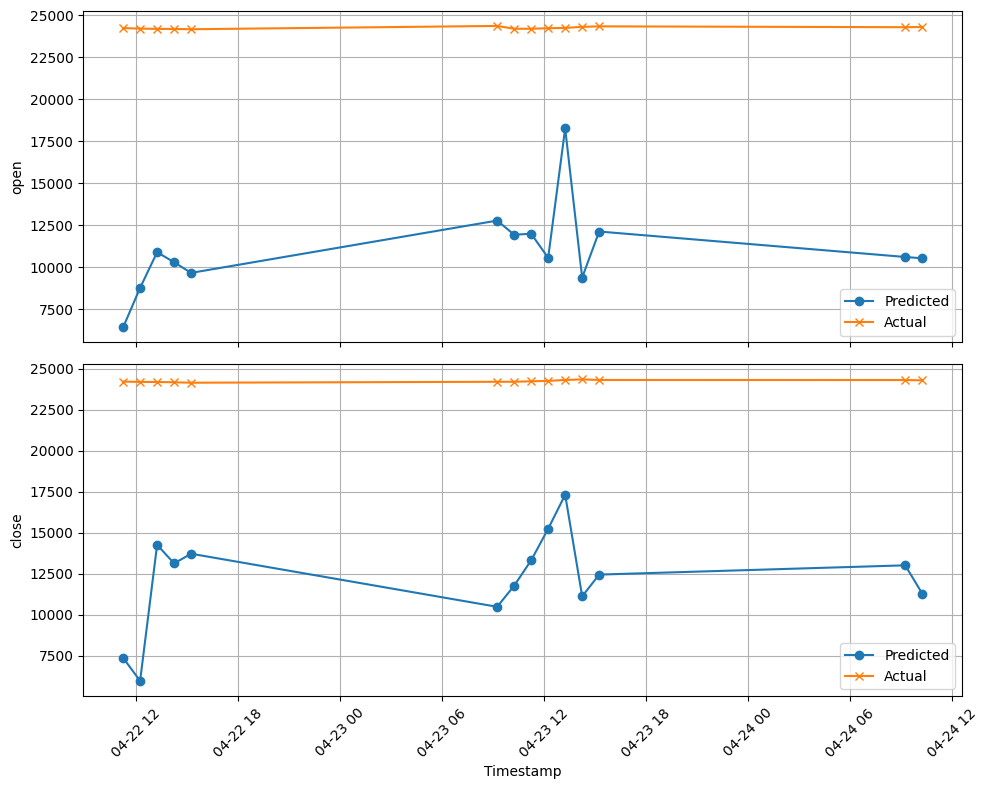

In [ ]:
import matplotlib.pyplot as plt
import torch

def predict(model, dataset, sample_idx=-1):
    #sample_idx = sample_idx if sample_idx != -1 else len(dataset) - 1
    model.eval()
    
    with torch.no_grad():
        X, y = dataset[sample_idx]
        prediction = model(X.unsqueeze(0).to(DEVICE)).cpu().numpy()
        print(np.shape(prediction))

    # Reshape and inverse transform
    true_values = dataset.y[sample_idx].reshape(OUTPUT_SIZE, OUTPUT_DIM)
    prediction = dataset.inverse_transform_target(prediction)
    true_values = dataset.inverse_transform_target(true_values)[0]

    # Extract timestamps for plotting
    timestamps = [
        dataset.df.iloc[sample_idx + i + dataset.sequence_length]['timestamp']
        for i in range(OUTPUT_SIZE)
    ]

    # Plotting
    fig, axs = plt.subplots(OUTPUT_DIM, 1, figsize=(10, 8), sharex=True)
    labels = TARGET_COLS
    
    for i in range(OUTPUT_DIM):
        axs[i].plot(timestamps, prediction[0, :, i], label='Predicted', marker='o')
        axs[i].plot(timestamps, true_values[:, i], label='Actual', marker='x')
        axs[i].set_ylabel(labels[i])
        axs[i].legend()
        axs[i].grid(True)

    axs[-1].set_xlabel("Timestamp")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Load best model and predict
#model.load_state_dict(torch.load('best_model.pth'))
predict(model, dataset,sample_idx=21151)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

def evaluate_metrics(model, val_loader, dataset, device):
    model.eval()
    preds = []
    actuals = []
    dates = []

    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(val_loader):
            X = X.to(device)
            output = model(X).cpu().numpy()  # (batch_size, 14, 4)
            y = y.view(-1, OUTPUT_SIZE, OUTPUT_DIM).numpy()   # (batch_size, 14, 4)
            
            # Get original indices for this batch
            start_idx = batch_idx * val_loader.batch_size
            end_idx = start_idx + X.shape[0]
            batch_indices = val_loader.dataset.indices[start_idx:end_idx]

            for i, original_idx in enumerate(batch_indices):
                for step in range(OUTPUT_SIZE):
                    target_idx = original_idx + SEQUENCE_LENGTH + step
                    if target_idx >= len(dataset.df):
                        continue
                    
                    # Get timestamp and date
                    timestamp = dataset.df.iloc[target_idx]['timestamp']
                    date = pd.to_datetime(timestamp).date()
                    preds.append(output[i, step, 1])
                    actuals.append(y[i, step, 1])
                    dates.append(date)

    # Create DataFrame for analysis
    df = pd.DataFrame({
        'date': dates,
        'pred': preds,
        'actual': actuals
    })

    # Calculate daily correlations
    daily_ic = []
    daily_rankic = []

    for date, group in df.groupby('date'):
        if len(group) < 2:
            continue  # Need at least 2 points for correlation
        
        # Pearson correlation
        ic, _ = pearsonr(group['pred'], group['actual'])
        if not np.isnan(ic):
            daily_ic.append(ic)
            
        # Spearman correlation
        rankic, _ = spearmanr(group['pred'], group['actual'])
        if not np.isnan(rankic):
            daily_rankic.append(rankic)

    # Calculate final metrics
    ic_mean = np.mean(daily_ic) if daily_ic else 0
    rankic_mean = np.mean(daily_rankic) if daily_rankic else 0
    ic_std = np.std(daily_ic) if daily_ic else 0
    rankic_std = np.std(daily_rankic) if daily_rankic else 0
    
    icir = ic_mean / ic_std if ic_std != 0 else 0
    rankicir = rankic_mean / rankic_std if rankic_std != 0 else 0

    return {
        'IC': ic_mean,
        'RankIC': rankic_mean,
        'ICIR': icir,
        'RankICIR': rankicir
    }

# Usage
model.load_state_dict(torch.load('best_model.pth'))
metrics = evaluate_metrics(model, val_loader, dataset, DEVICE)

print(f"Information Coefficient (IC): {metrics['IC']:.4f}")
print(f"Rank Information Coefficient (RankIC): {metrics['RankIC']:.4f}")
print(f"IC Information Ratio (ICIR): {metrics['ICIR']:.4f}")
print(f"RankIC Information Ratio (RankICIR): {metrics['RankICIR']:.4f}")

Information Coefficient (IC): 0.1347
Rank Information Coefficient (RankIC): 0.1133
IC Information Ratio (ICIR): 0.2534
RankIC Information Ratio (RankICIR): 0.2162
